## Importing libraries

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.3 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from math import log2
import torch
from torch import nn
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
import torch.optim as optim
from transformers import get_scheduler
from torchmetrics import Accuracy
import random
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import os

seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ViT model

In [ ]:
config = ViTConfig.from_pretrained('google/vit-base-patch16-224', num_labels=10)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', config=config, ignore_mismatched_sizes=True)

model.classifier = nn.Linear(model.config.hidden_size, 10)
model.classifier.to(device)

if model.classifier.out_features != 10:
    model.classifier = nn.Linear(model.classifier.in_features, 10)
model.classifier.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)

## Loading model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/ViT_model_weights.pth"))

<All keys matched successfully>

## Compute inception score


In [ ]:
data = np.load('/content/drive/MyDrive/Generated images/pixelcnn.npy')
data = data[:10000]
data.shape

(10000, 1, 28, 28)

In [ ]:
class ReconstructedDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            root_dir (string): Directory with all the reconstructed images and labels.csv.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx])
        image = torch.cat([image] * 3, dim=0)
        return transforms.Resize((224, 224))(image)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,), (0.5,))
])

reconstructed_dataset = ReconstructedDataset(data, transform=None)
reconstructed_loader = DataLoader(reconstructed_dataset, batch_size=32, shuffle=False)

In [ ]:
model.to(device)
logits = []
for images in reconstructed_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(pixel_values=images)
        logits.append(outputs.logits)

In [ ]:
np.save('/content/drive/MyDrive/Generated images/pixelcnn_logits.npy', combined_logits.cpu().numpy())

In [ ]:
def getMarginal(logits):
    return torch.mean(logits, dim=0)

In [ ]:
marginal = getMarginal(torch.softmax(combined_logits, dim=1))

In [ ]:
np.save('/content/drive/MyDrive/Generated images/pixelcnn_marginal.npy', marginal.cpu().numpy())

In [ ]:
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [ ]:
def getIS(marginal, logits):
    IS = []
    for logit in logits:
        logit = torch.softmax(logit, dim=0)
        IS.append(kl_divergence(marginal, logit).item())
    return IS

In [ ]:
scores = getIS(marginal, combined_logits)

In [ ]:
scores = np.array(scores)
np.save('/content/drive/MyDrive/Generated images/pixelcnn_is_scores.npy', scores)

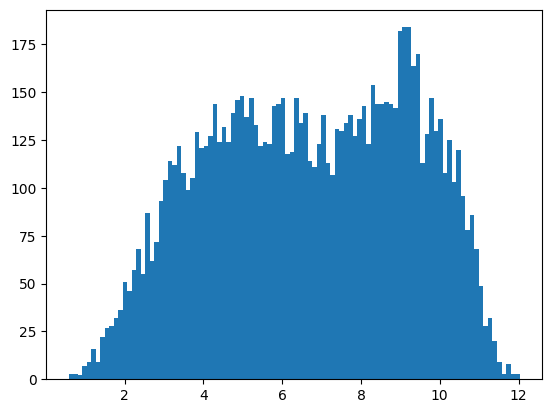

In [ ]:
# Diffusion
plt.hist(scores, bins=100)
plt.show()

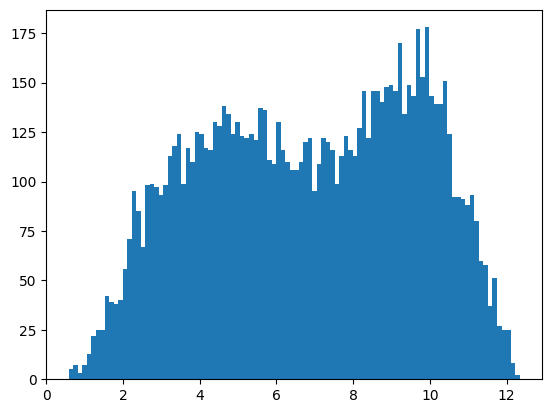

In [ ]:
# PixelCNN
plt.hist(scores, bins=100)
plt.show()

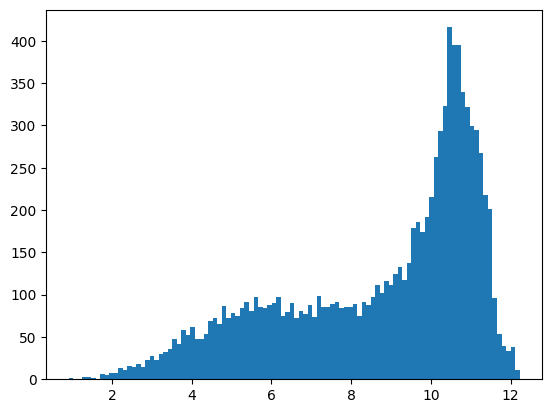

In [ ]:
# DCGAN
plt.hist(scores, bins=100)
plt.show()

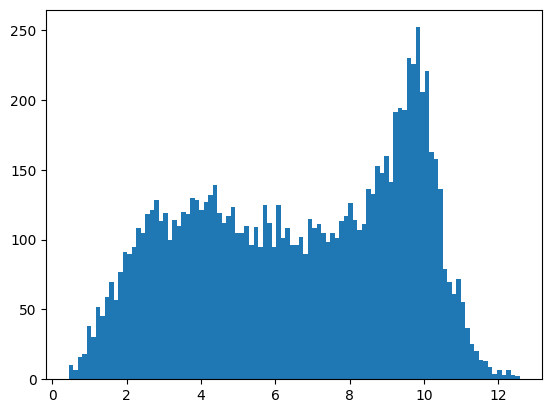

In [ ]:
# Simple GAN
plt.hist(scores, bins=100)
plt.show()

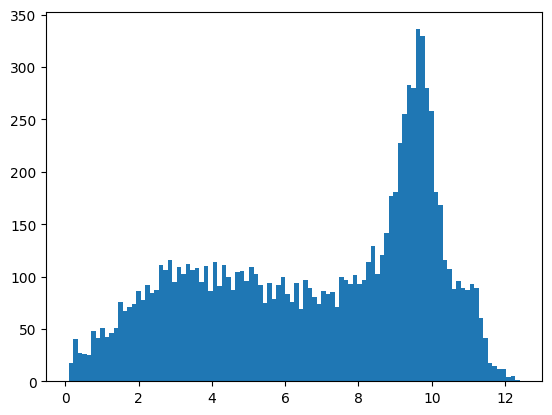

In [ ]:
# Simple VAE
plt.hist(scores, bins=100)
plt.show()

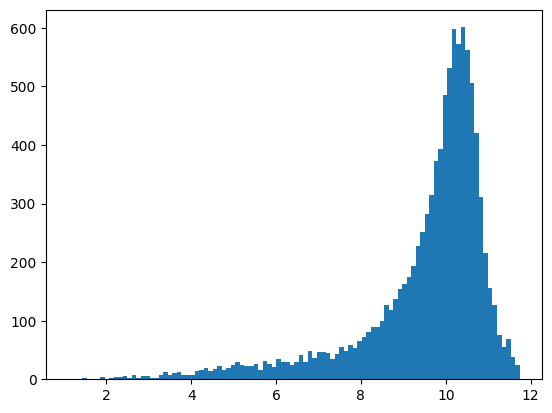

In [ ]:
# DCVAE
plt.hist(scores, bins=100)
plt.show()